In [1]:
import argparse
from box import Box
import yaml

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from model_logreg_dn import ModelLogisicRegressionMvn
from dataset_npz import DataModuleFromNPZ

import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
pl.seed_everything(2202)
dm = DataModuleFromNPZ(
    data_dir="data_logistic_regression_2d",
    feature_labels=["inputs", "targets"],
    batch_size=256,
    num_workers=4,
    shuffle_training=False
)

Global seed set to 2202


# Train or load a model

In [3]:
if True: #switch to True to train and save a model within this notebook, switch back to False to evaluate
    dm.prepare_data()
    dm.setup(stage="fit")
    model_mvn = ModelLogisicRegressionMvn(
            2,
            dm.size_train(),
            is_diagonal=False,
            scale_prior=10.0,
            optimizer_name="RMSprop", 
            optimizer_lr=0.1,
            save_path="runs/models/multivariate")
    trainer = Trainer(max_epochs=50)
    trainer.fit(model_mvn, dm)
    trainer.test(model_mvn, dm)
    model_mvn.eval()
    
    model_diag = ModelLogisicRegressionMvn(
            2,
            dm.size_train(),
            is_diagonal=True,
            scale_prior=10.0,
            optimizer_name="RMSprop", 
            optimizer_lr=0.1,
            save_path="runs/models/diagonal")
    trainer = Trainer(max_epochs=100)
    trainer.fit(model_diag, dm)
    trainer.test(model_diag, dm)
    model_diag.eval()
    
else:
    dm.prepare_data()
    dm.setup(stage="fit")
    size_data_train = dm.size_train()
    
    SAVE_PATH = "runs/models/multivariate/loss_val-epoch=160-step=644.ckpt" # change this to your saved model in the same directory!!!
    model_mvn = ModelLogisicRegressionMvn.load_from_checkpoint(SAVE_PATH, size_data=size_data_train)
    dm.setup(stage="test")
    trainer = Trainer(max_epochs=50)
    trainer.test(model_mvn, dm)
    model_mvn.eval()
    
    SAVE_PATH = "runs/models/diagonal/loss_val-epoch=98-step=396.ckpt" # change this to your saved model in the same directory!!!
    model_diag = ModelLogisicRegressionMvn.load_from_checkpoint(SAVE_PATH, size_data=size_data_train)
    trainer = Trainer()
    trainer.test(model_diag, dm)
    model_diag.eval()
    
    

"dim":                2
"is_diagonal":        False
"n_nodes_quadrature": 9
"n_samples_mc":       8
"optimizer_lr":       0.1
"optimizer_name":     RMSprop
"scale_prior":        10.0
"size_data":          1024


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/Users/bcseke/vwai/argmax-ai/teaching/tum-vir-exercise/venv-tum/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/bcseke/vwai/argmax-ai/teaching/tum-vir-exercise/logistic-regression/runs/models/multivariate exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type               | Params
---------------------------------------------------
0 | feature_map | Sequential         | 0     
1 | logit       | LikelihoodLogistic | 28    
---------------------------------------------------
8         Trainable params
28        Non-trainable params
36        Total params
0.000 

/Users/bcseke/vwai/argmax-ai/teaching/tum-vir-exercise/venv-tum/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████████████████████████████

Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.19s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|█████████████████████████████████████

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.24s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.24s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|█████████████████████████████████████

Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|█████████████████████████████████████

Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.11s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.91s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.47s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|█████████████████████████████████████

Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|█████████████████████████████████████

Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.42s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|█████████████████████████████████████

Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|█████████████████████████████████████

Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.10s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|█████████████████████████████████████

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.24s/it, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.71s/it, v_num=24]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.71s/it, v_num=24]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 60.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        acc_test               0.9228515625
         kl_test             6.196765422821045
        logp_test           -165.2203826904297
        loss_test           171.41714477539062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/Users/bcseke/vwai/argmax-ai/teaching/tum-vir-exercise/venv-tum/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/bcseke/vwai/argmax-ai/teaching/tum-vir-exercise/logistic-regression/runs/models/diagonal exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type               | Params
---------------------------------------------------
0 | feature_map | Sequential         | 0     
1 | logit       | LikelihoodLogistic | 28    
---------------------------------------------------
4         Trainable params
28        Non-trainable params
32        Total params
0.000     

"dim":                2
"is_diagonal":        True
"n_nodes_quadrature": 9
"n_samples_mc":       8
"optimizer_lr":       0.1
"optimizer_name":     RMSprop
"scale_prior":        10.0
"size_data":          1024
Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████████████████████

Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|█████████████████████████████████████

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.94s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|█████████████████████████████████████

Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.92s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.85s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 2

Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.10s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|████████████████████████████████████████

Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.24s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.22s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.73s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|████████████████████████████████████████

Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|████████████████████████████████████████

Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.00s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.97s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|████████████████████████████████████████

Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.10s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 56: 100%|████████████████████████████████████████

Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 63: 100%|████████████████████████████████████████

Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 70: 100%|████████████████████████████████████████

Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.03s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 77: 100%|████████████████████████████████████████

Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 84: 100%|████████████████████████████████████████

Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.30s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.26s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.61s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 91: 100%|████████████████████████████████████████

Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/it, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 98: 100%|████████████████████████████████████████

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=26]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it, v_num=26]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 152.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        acc_test               0.9228515625
         kl_test            4.6571526527404785
        logp_test           -165.06617736816406
        loss_test           169.72332763671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Load all training and testing data for plotting

In [4]:
dm_plotting = DataModuleFromNPZ(
    data_dir="data_logistic_regression_2d",
    feature_labels=["inputs", "targets"],
    batch_size=-1,
    num_workers=4,
    shuffle_training=False
)
dm_plotting.prepare_data()
dm_plotting.setup(stage="fit")
for f,l in dm_plotting.train_dataloader():
    features_train, labels_train = f, l
dm_plotting.setup(stage="test")
for f,l in dm_plotting.test_dataloader():
    features_test, labels_test = f, l

# Compute class probabilities for plotting

In [5]:
x, y = np.meshgrid(np.arange(-1.1,1.1,0.025), np.arange(-1.1,1.1,0.025))
features_plot = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
p_plot_mvn  = model_mvn(torch.tensor(features_plot, dtype=torch.float32)).detach().cpu().numpy().reshape(x.shape)
p_plot_diag = model_diag(torch.tensor(features_plot, dtype=torch.float32)).detach().cpu().numpy().reshape(x.shape)

# Plot

Text(0.5, 1.0, 'Diagonal model: Test data')

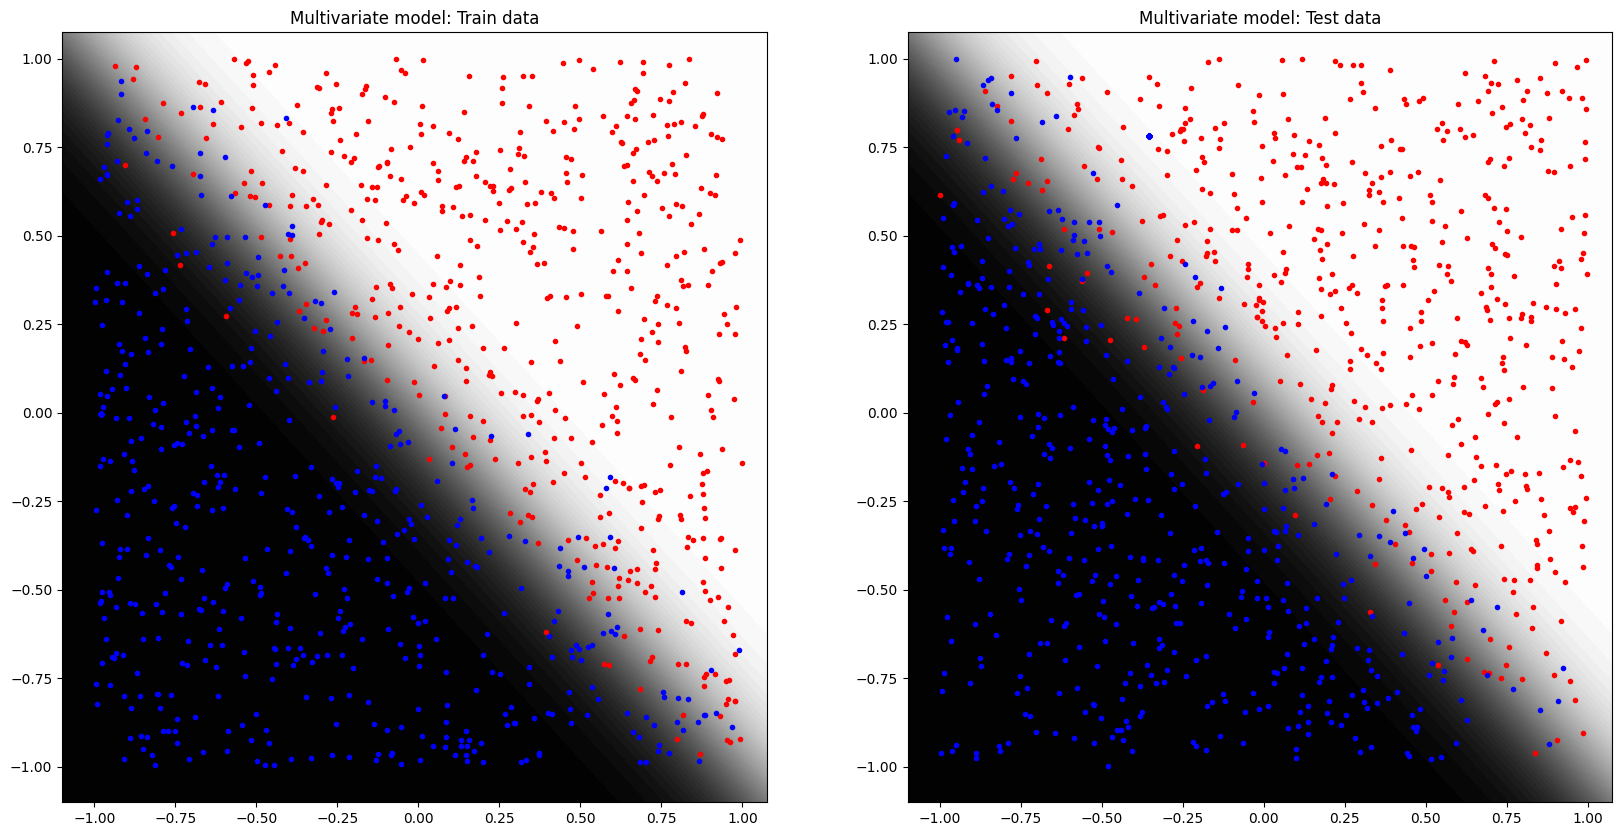

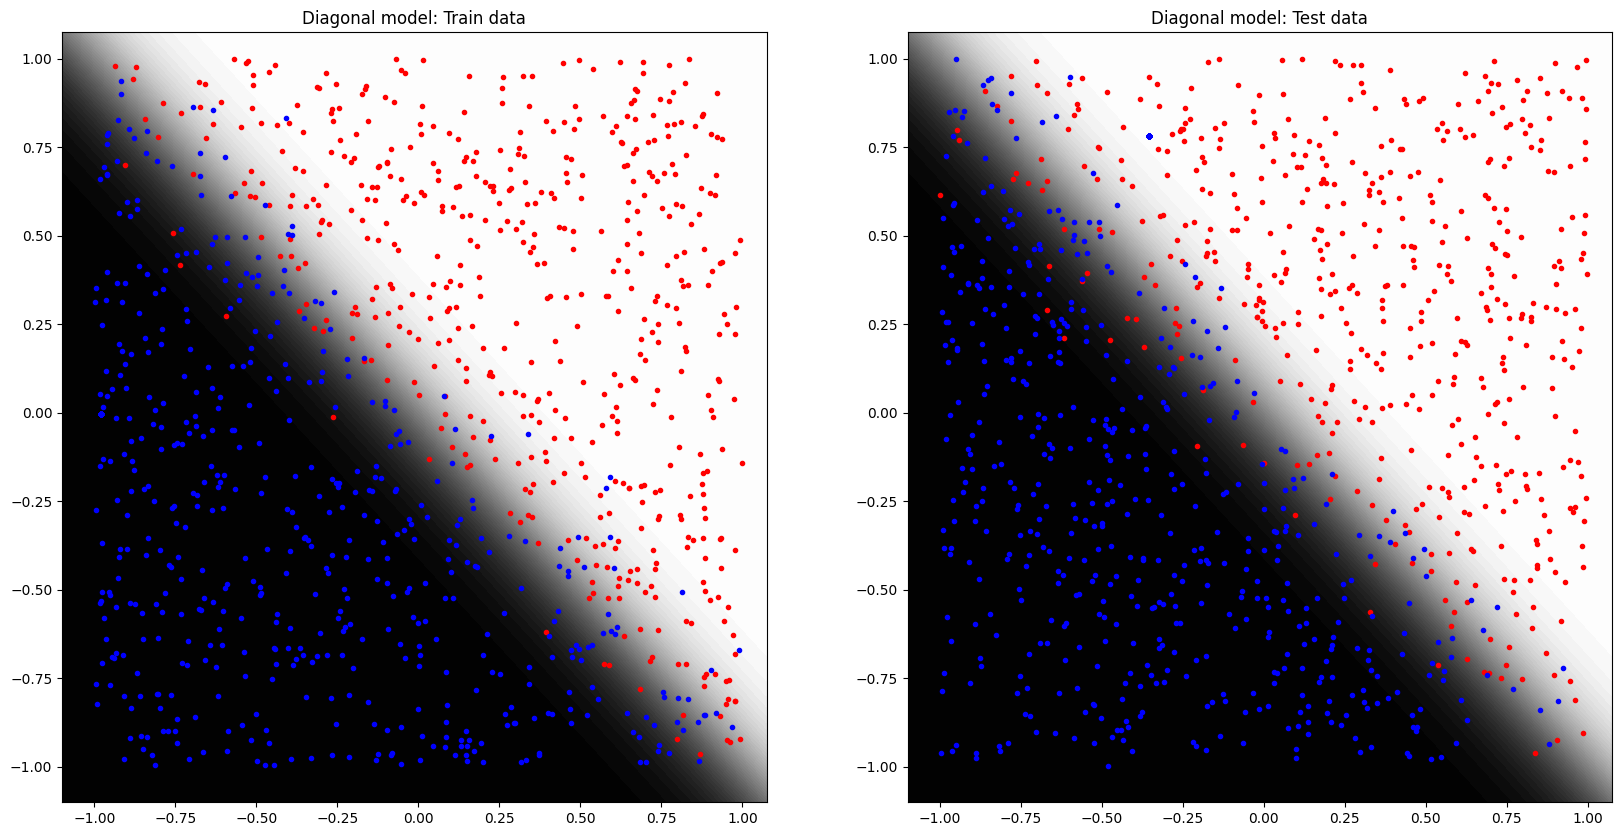

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

Ip = np.argwhere(labels_train[:] > 0.5)
In = np.argwhere(labels_train[:] < 0.5)
ax[0].contourf(x, y, p_plot_mvn, 50, cmap=plt.get_cmap("gray"))
ax[0].plot(features_train[Ip,0], features_train[Ip,1], ".", color = "red")
ax[0].plot(features_train[In,0], features_train[In,1], ".", color = "blue")
ax[0].set_title("Multivariate model: Train data")

Ip = np.argwhere(labels_test[:] > 0.5)
In = np.argwhere(labels_test[:] < 0.5)
ax[1].contourf(x, y, p_plot_mvn, 50, cmap=plt.get_cmap("gray"))
ax[1].plot(features_test[Ip,0], features_test[Ip,1], ".", color = "red")
ax[1].plot(features_test[In,0], features_test[In,1], ".", color = "blue")
ax[1].set_title("Multivariate model: Test data")

fig, ax = plt.subplots(1,2, figsize=(20,10))

Ip = np.argwhere(labels_train[:] > 0.5)
In = np.argwhere(labels_train[:] < 0.5)
ax[0].contourf(x, y, p_plot_diag, 50, cmap=plt.get_cmap("gray"))
ax[0].plot(features_train[Ip,0], features_train[Ip,1], ".", color = "red")
ax[0].plot(features_train[In,0], features_train[In,1], ".", color = "blue")
ax[0].set_title("Diagonal model: Train data")

Ip = np.argwhere(labels_test[:] > 0.5)
In = np.argwhere(labels_test[:] < 0.5)
ax[1].contourf(x, y, p_plot_diag, 50, cmap=plt.get_cmap("gray"))
ax[1].plot(features_test[Ip,0], features_test[Ip,1], ".", color = "red")
ax[1].plot(features_test[In,0], features_test[In,1], ".", color = "blue")
ax[1].set_title("Diagonal model: Test data")



# Print model parameters

In [7]:
print("Learned distribution parameters")
print("weights mean")
print(model_mvn.weights_loc.detach().cpu().numpy())
print("weights covariance")
L = model_mvn.weights_chol().detach().cpu().numpy()
print(np.matmul(L,L.T))


print("Learned distribution parameters")
print("weights mean")
print(model_diag.weights_loc.detach().cpu().numpy())
print("weights covariance")
L = model_diag.weights_chol().detach().cpu().numpy()
print(np.matmul(L,L.T))

Learned distribution parameters
weights mean
[[8.403504]
 [8.403087]]
weights covariance
[[0.37469584 0.3986848 ]
 [0.3986848  0.48620892]]
Learned distribution parameters
weights mean
[[9.7463455]
 [9.776007 ]]
weights covariance
[[0.9856618 0.       ]
 [0.        0.847405 ]]


# Plot Bayesian  posterior distribution of weights

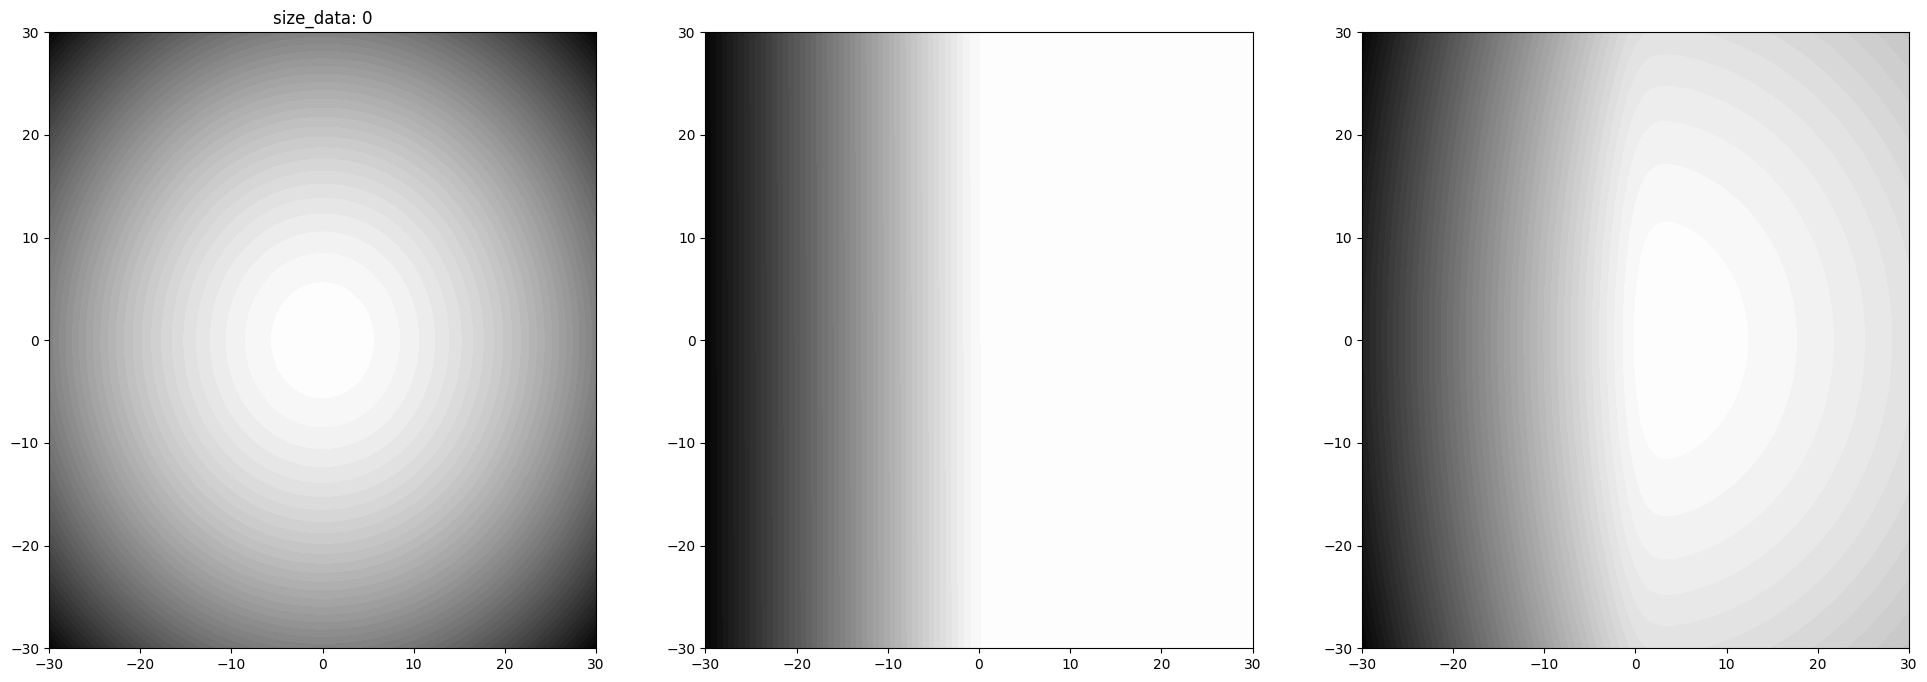

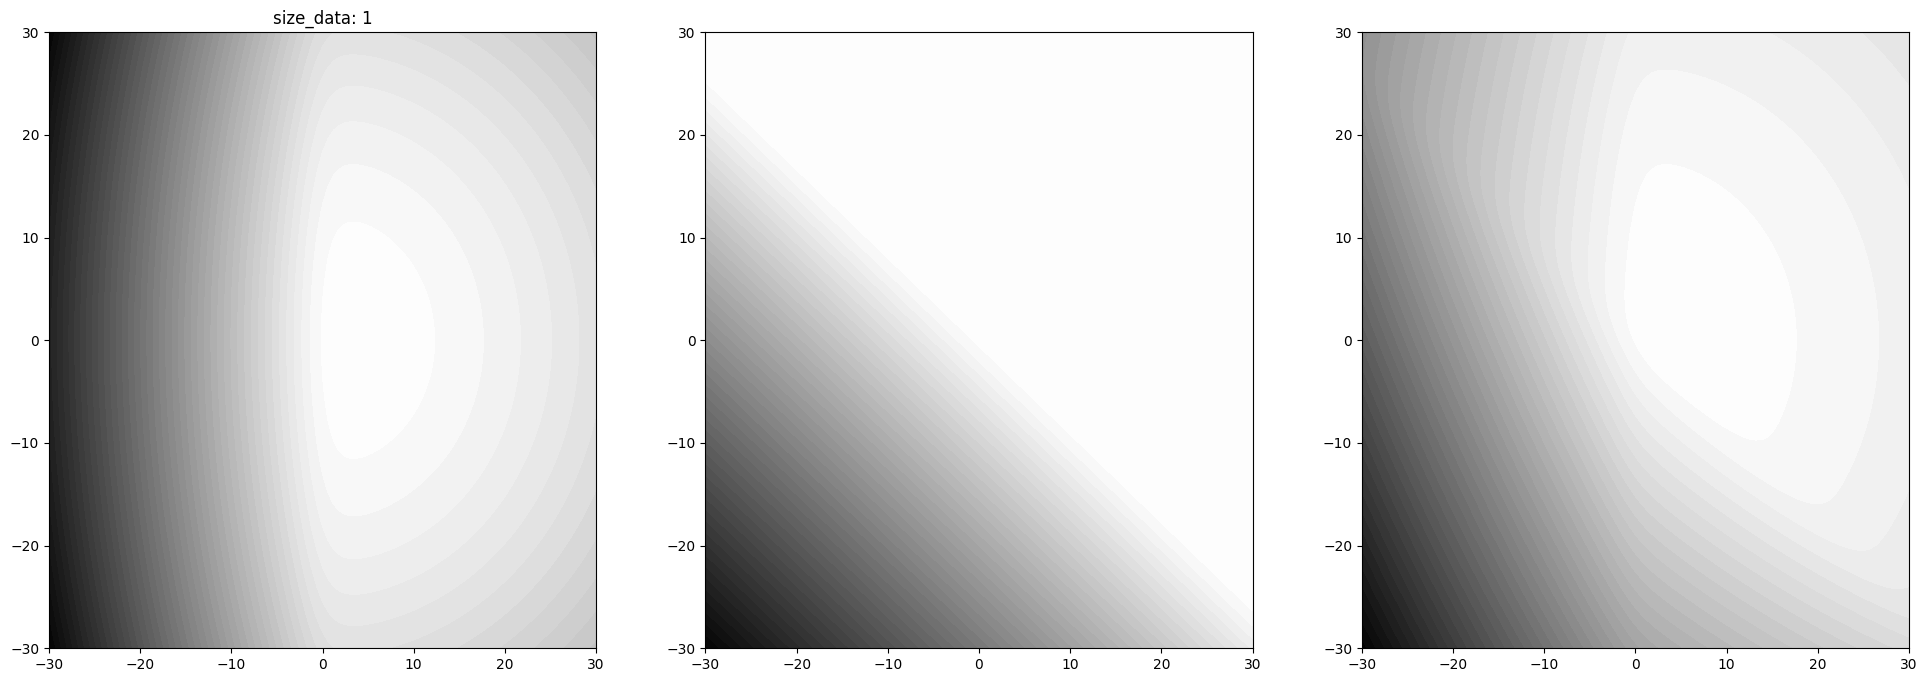

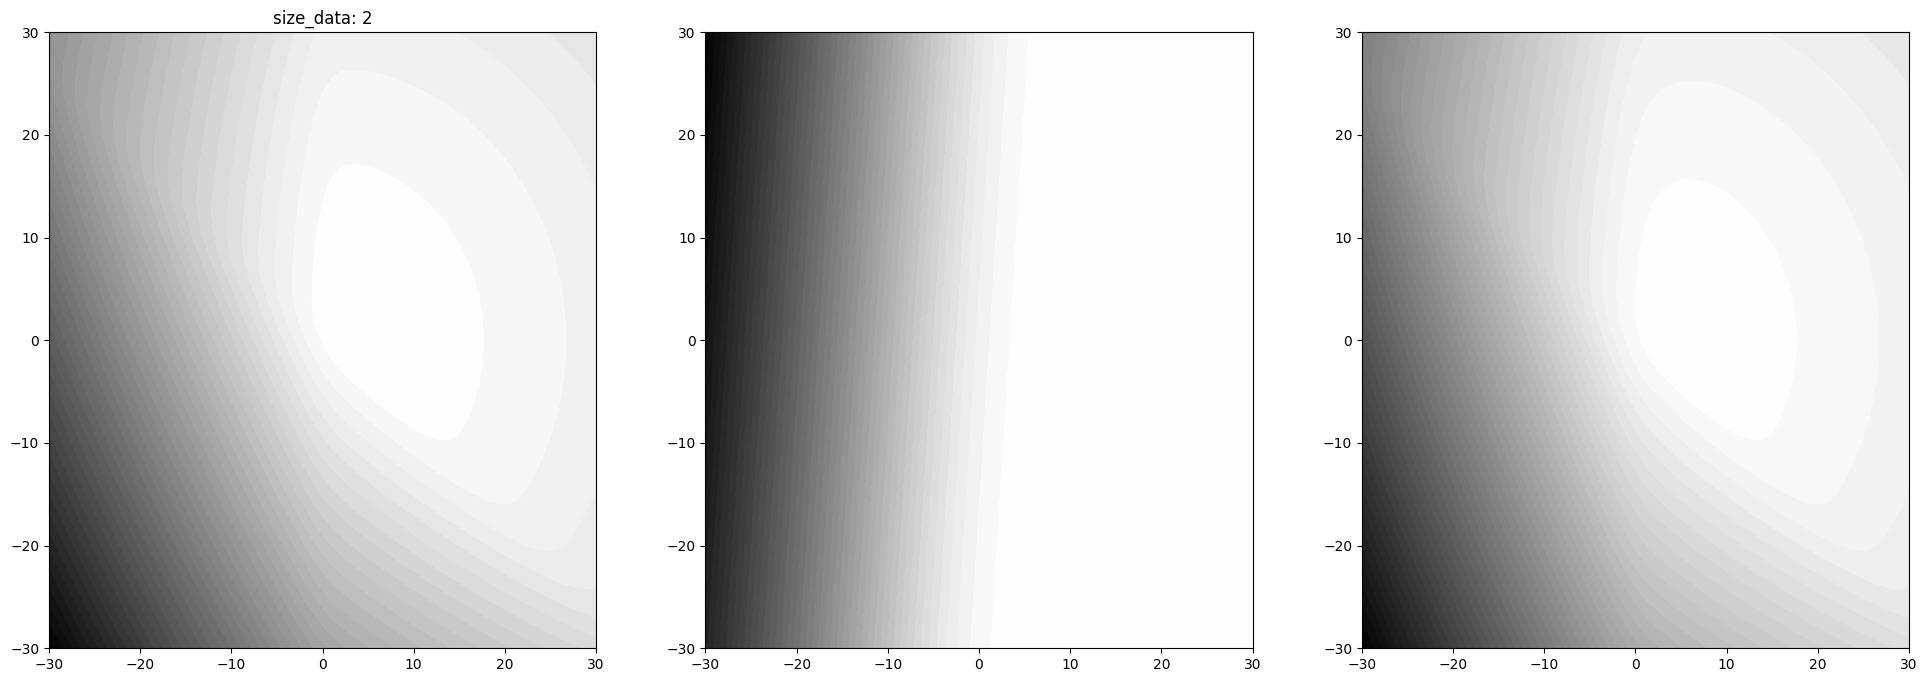

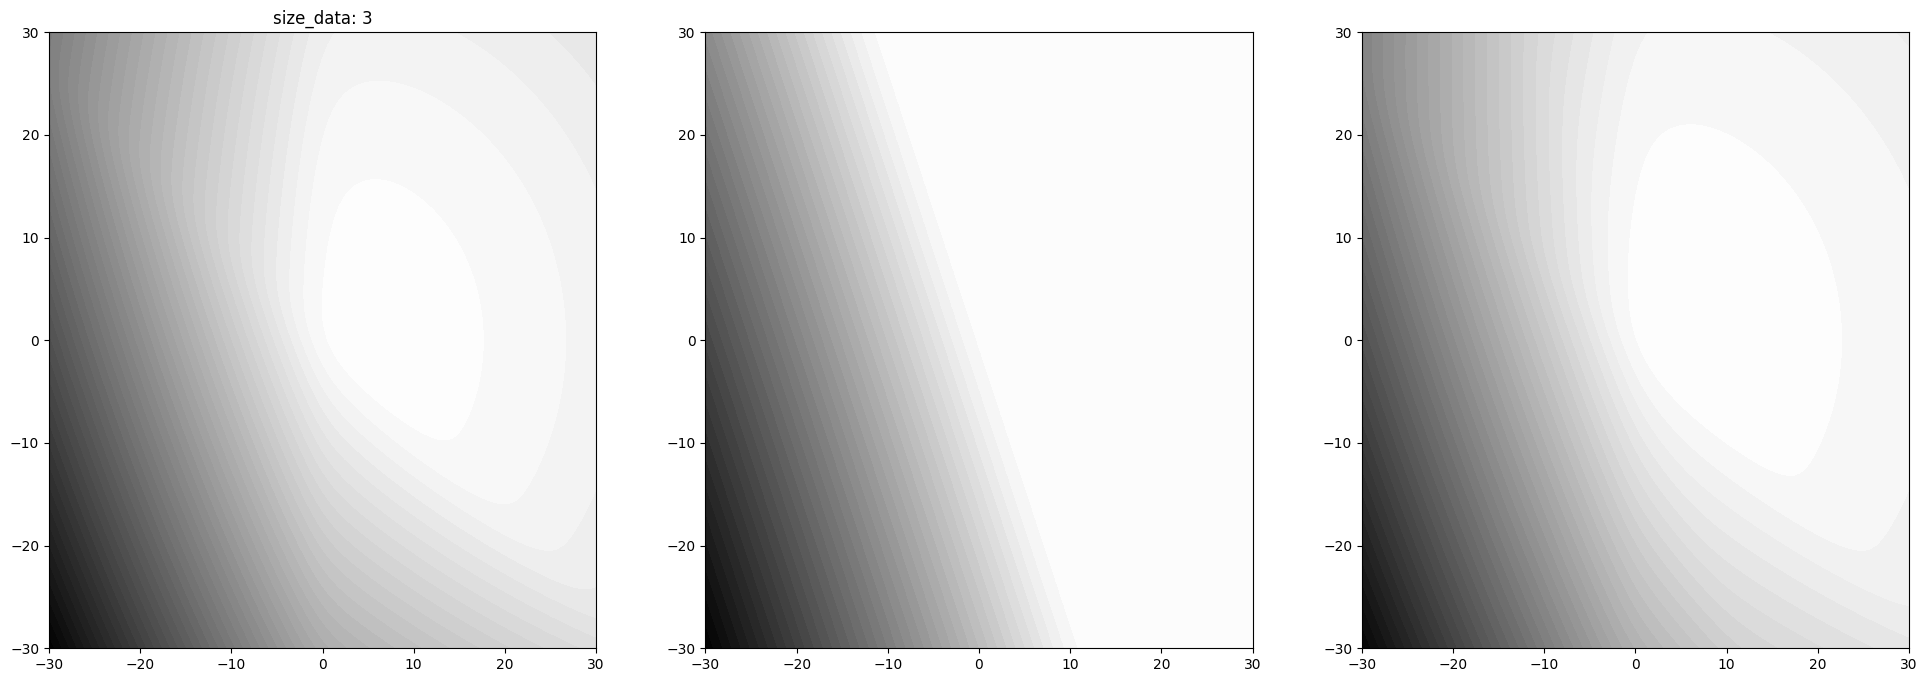

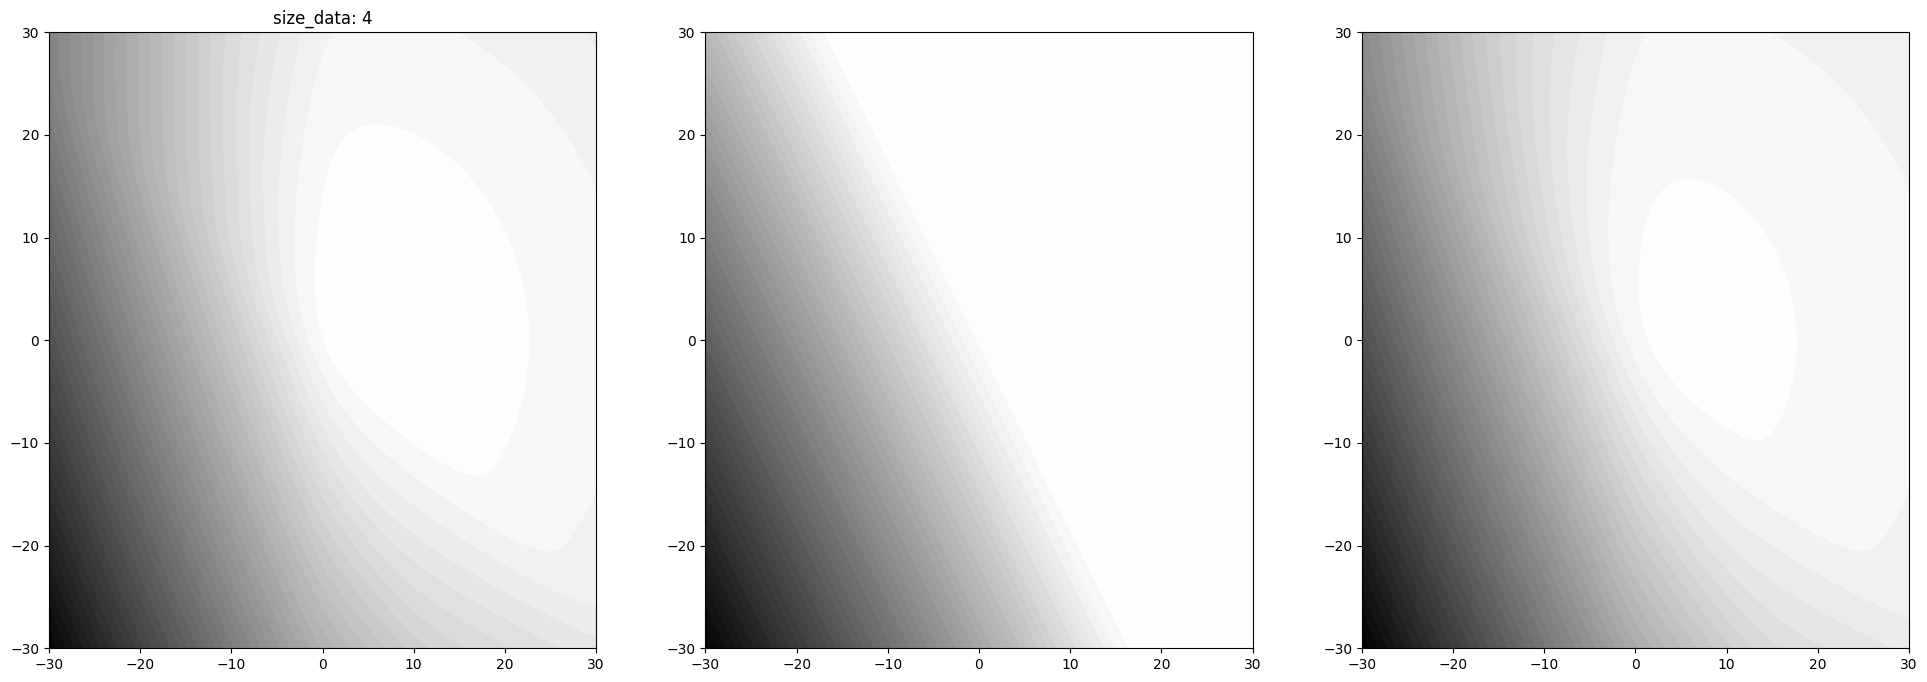

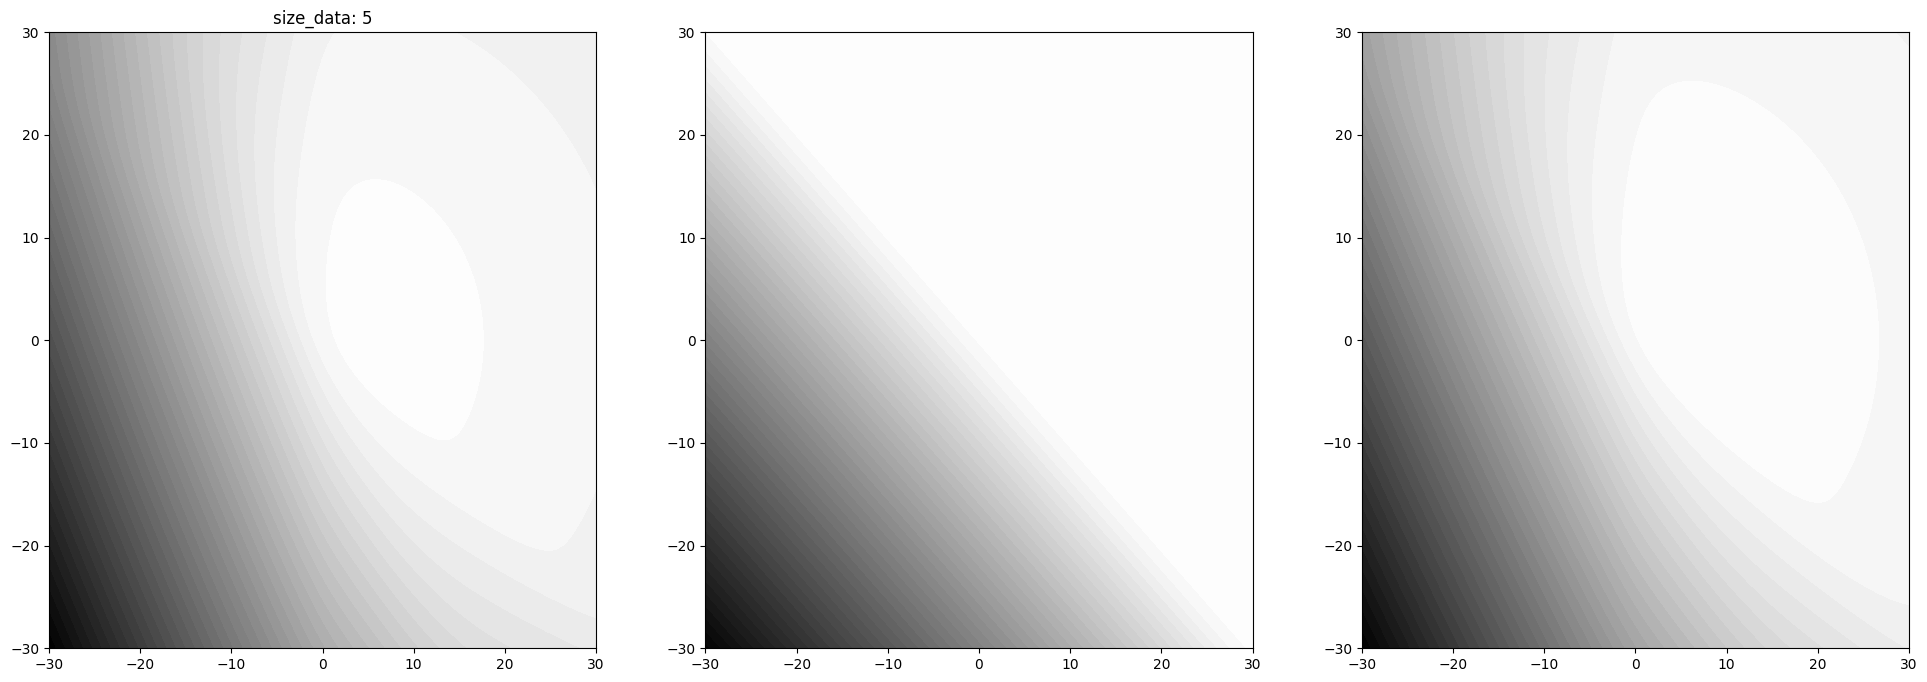

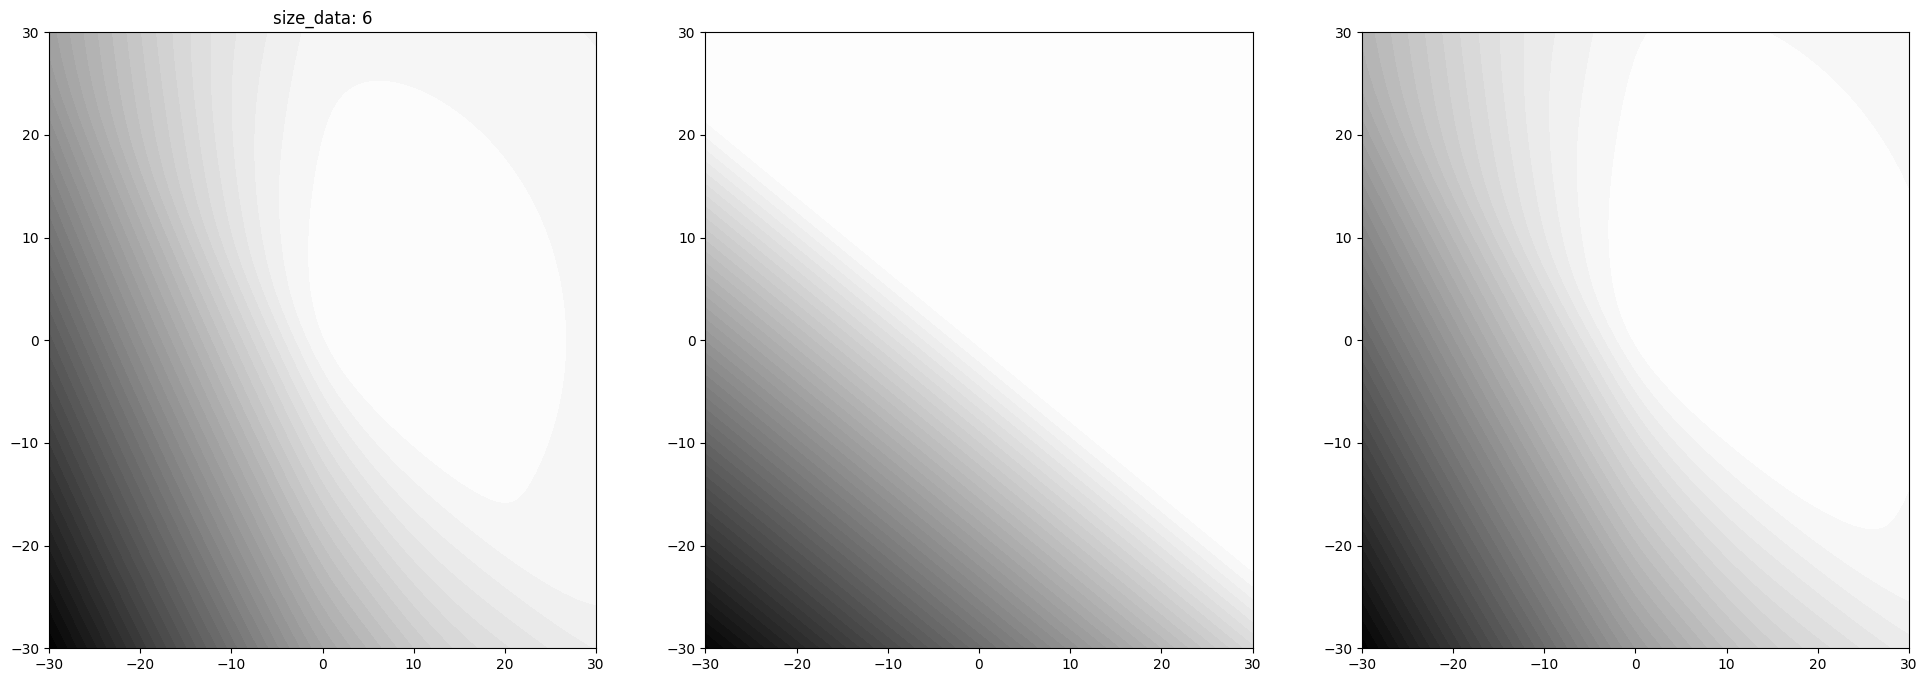

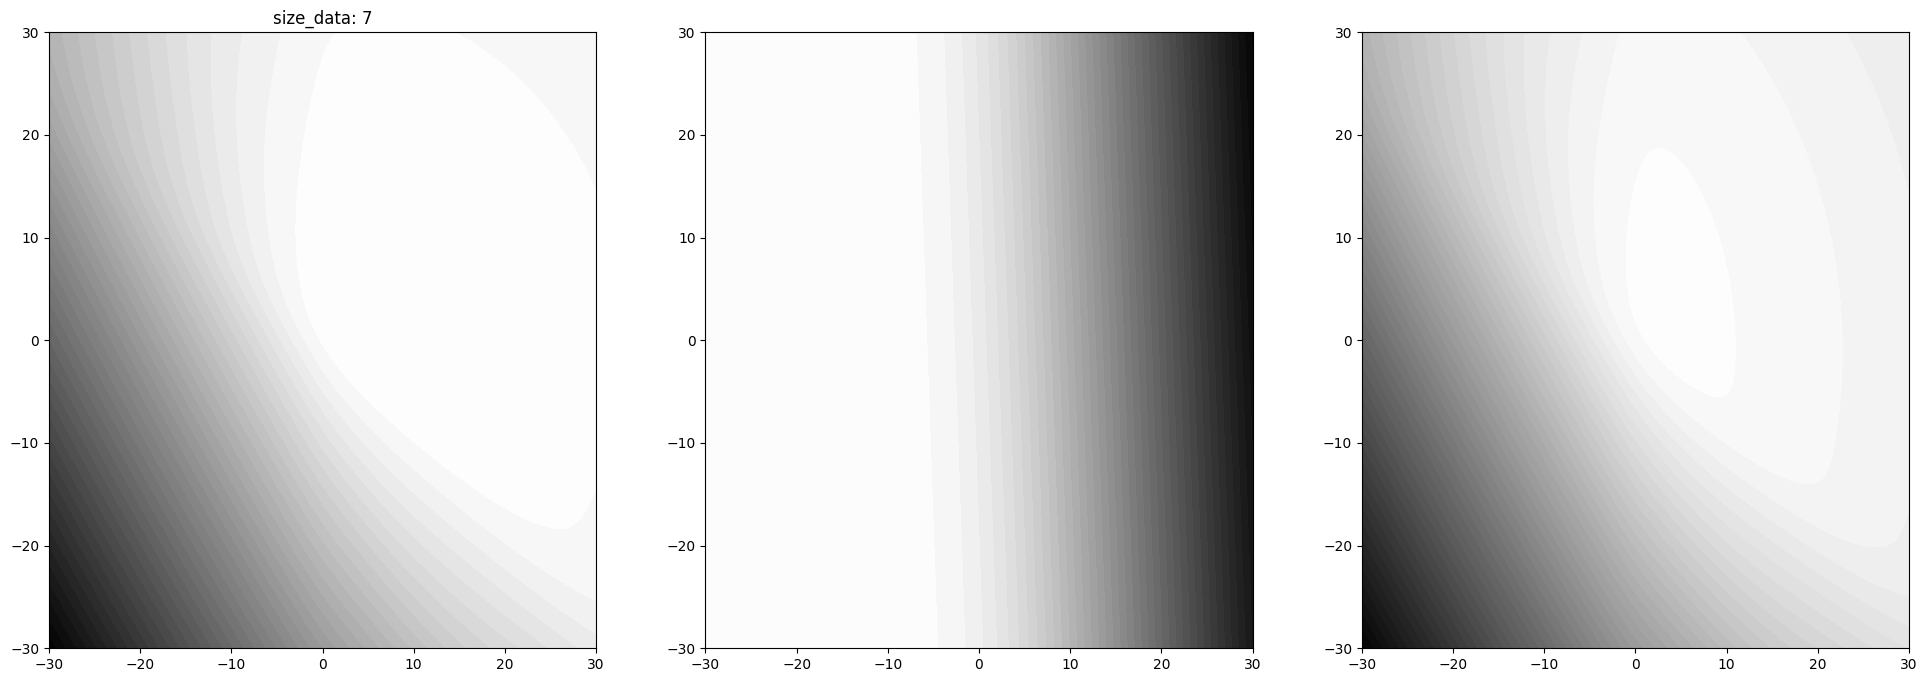

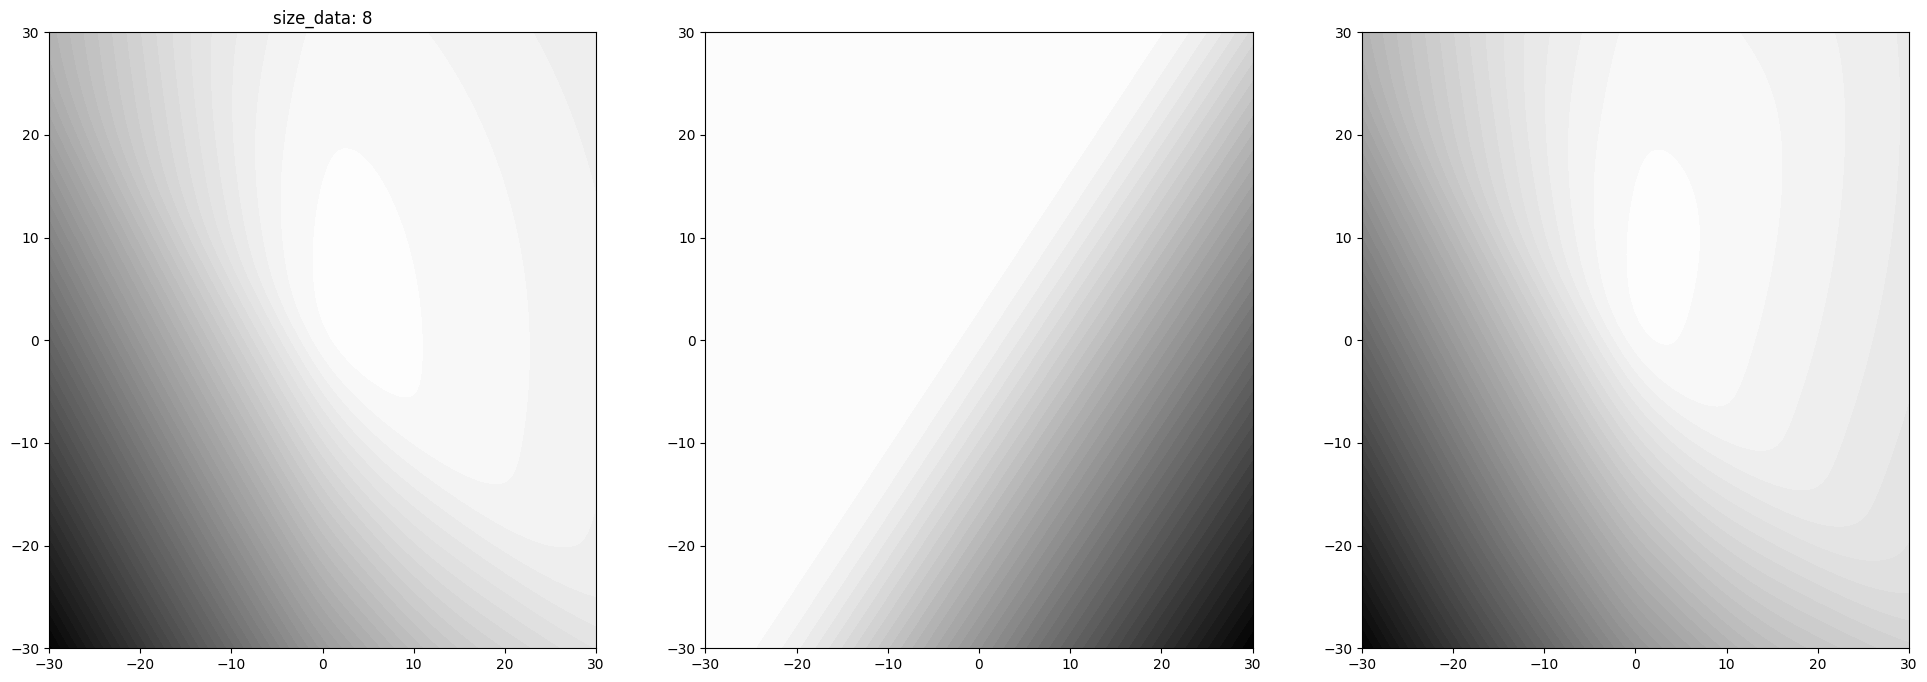

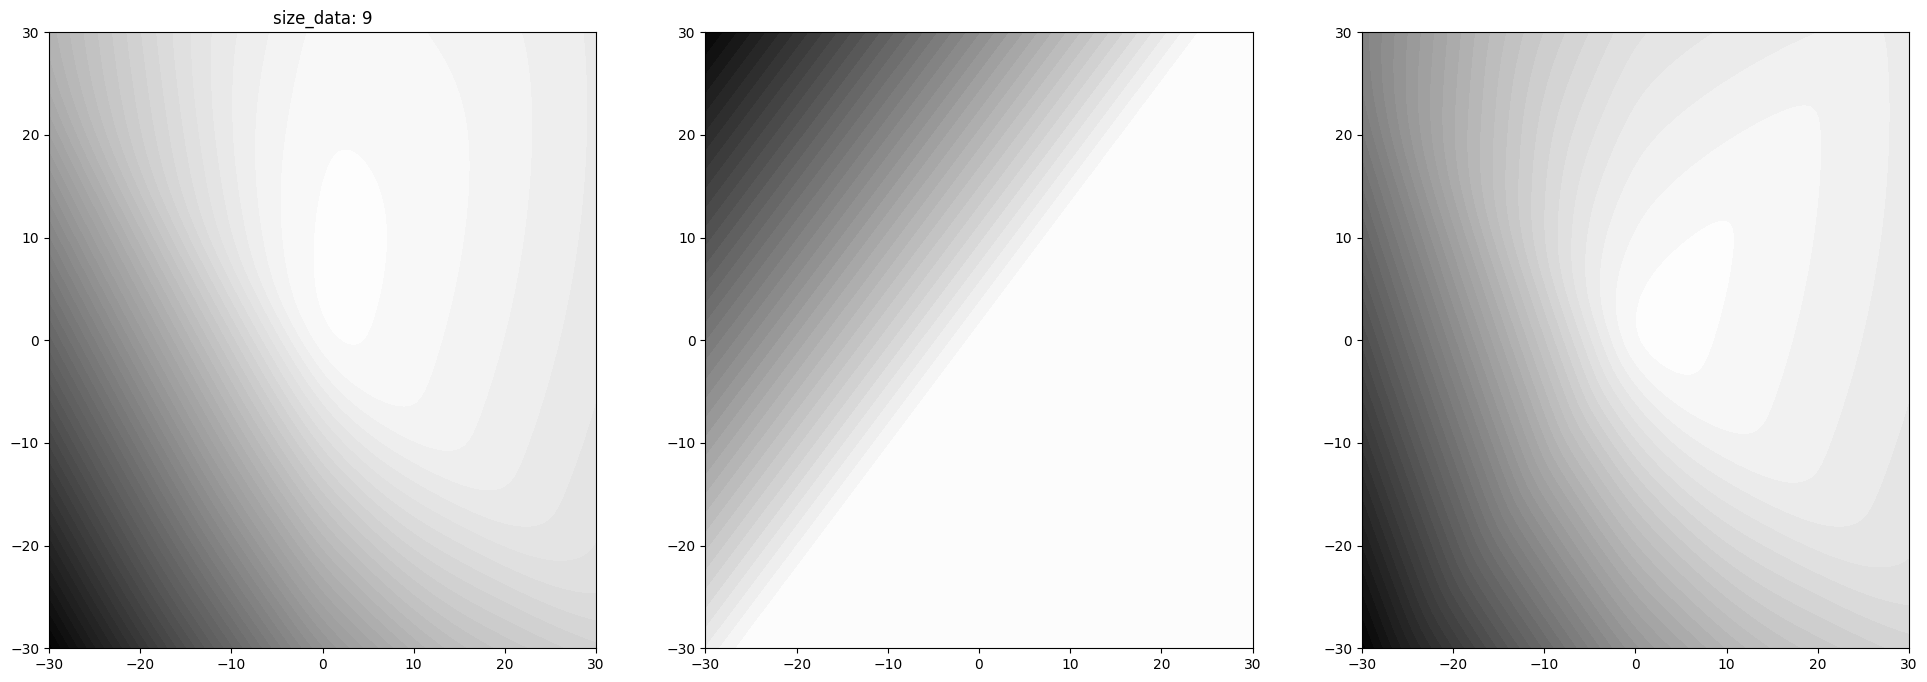

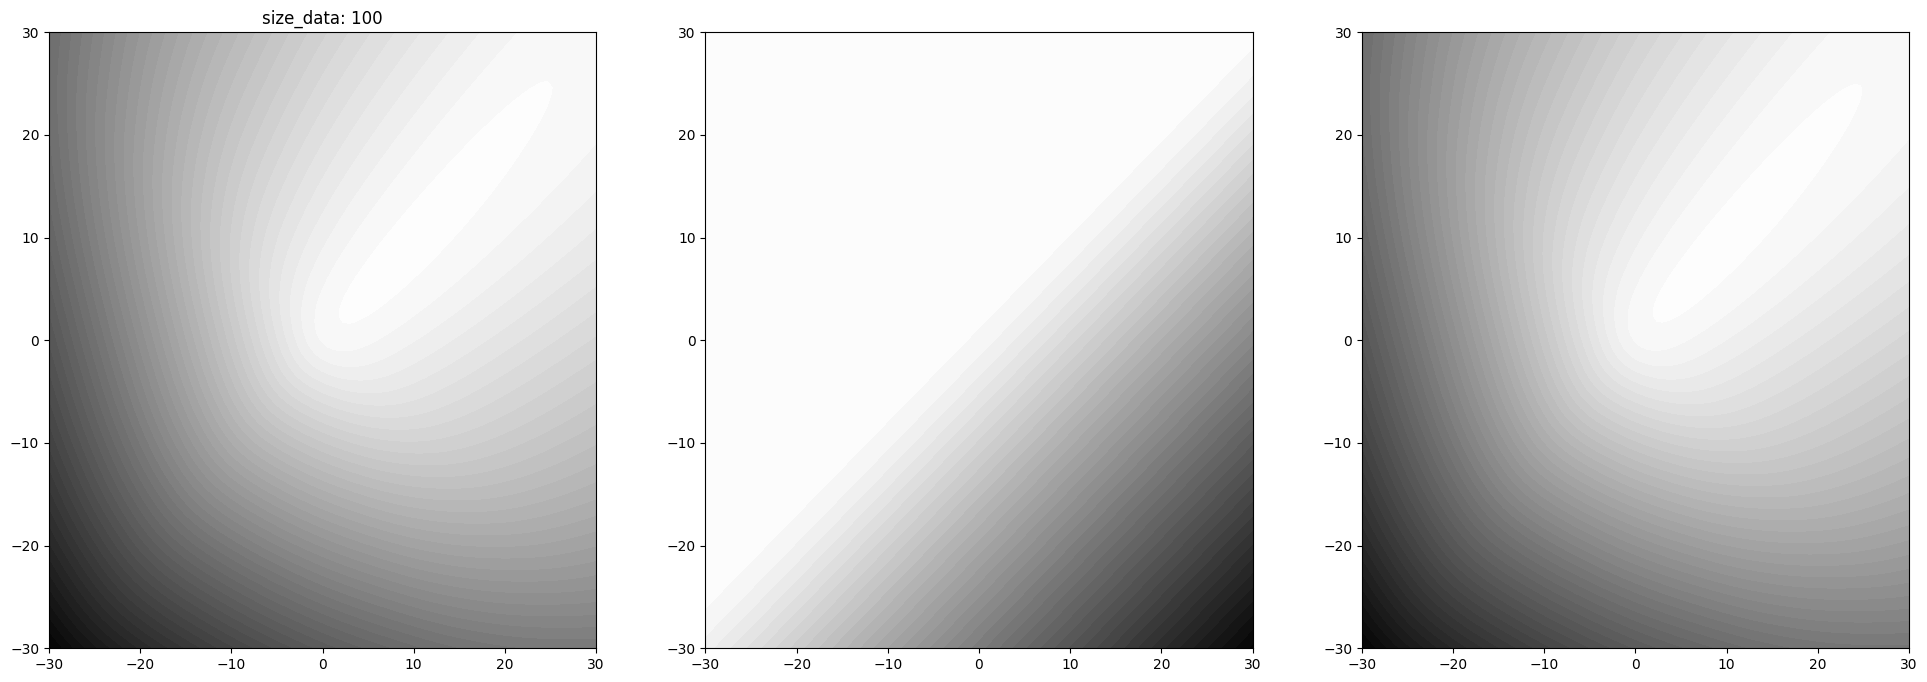

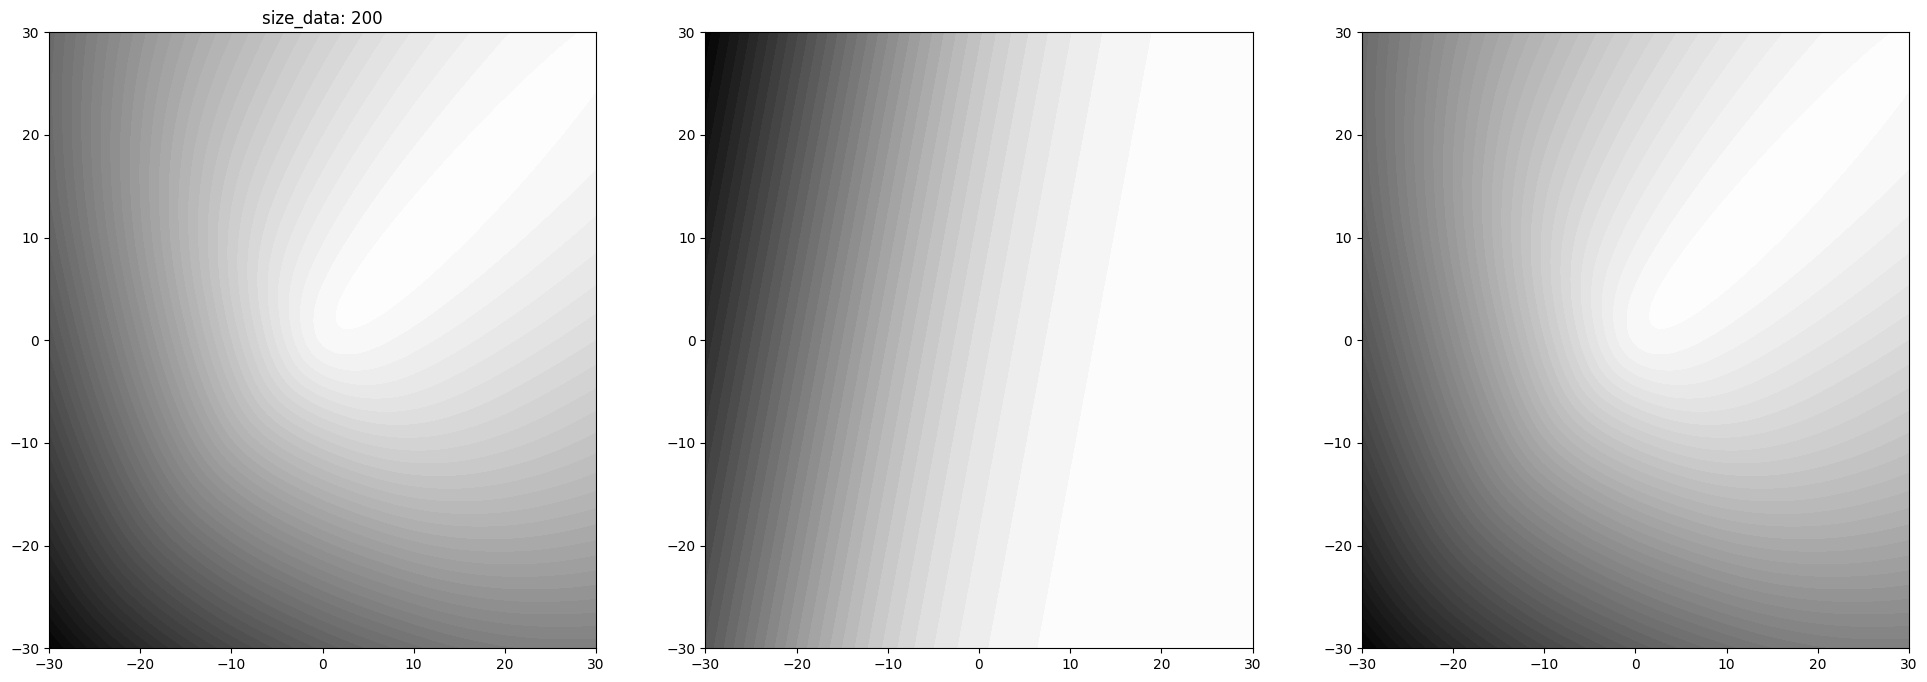

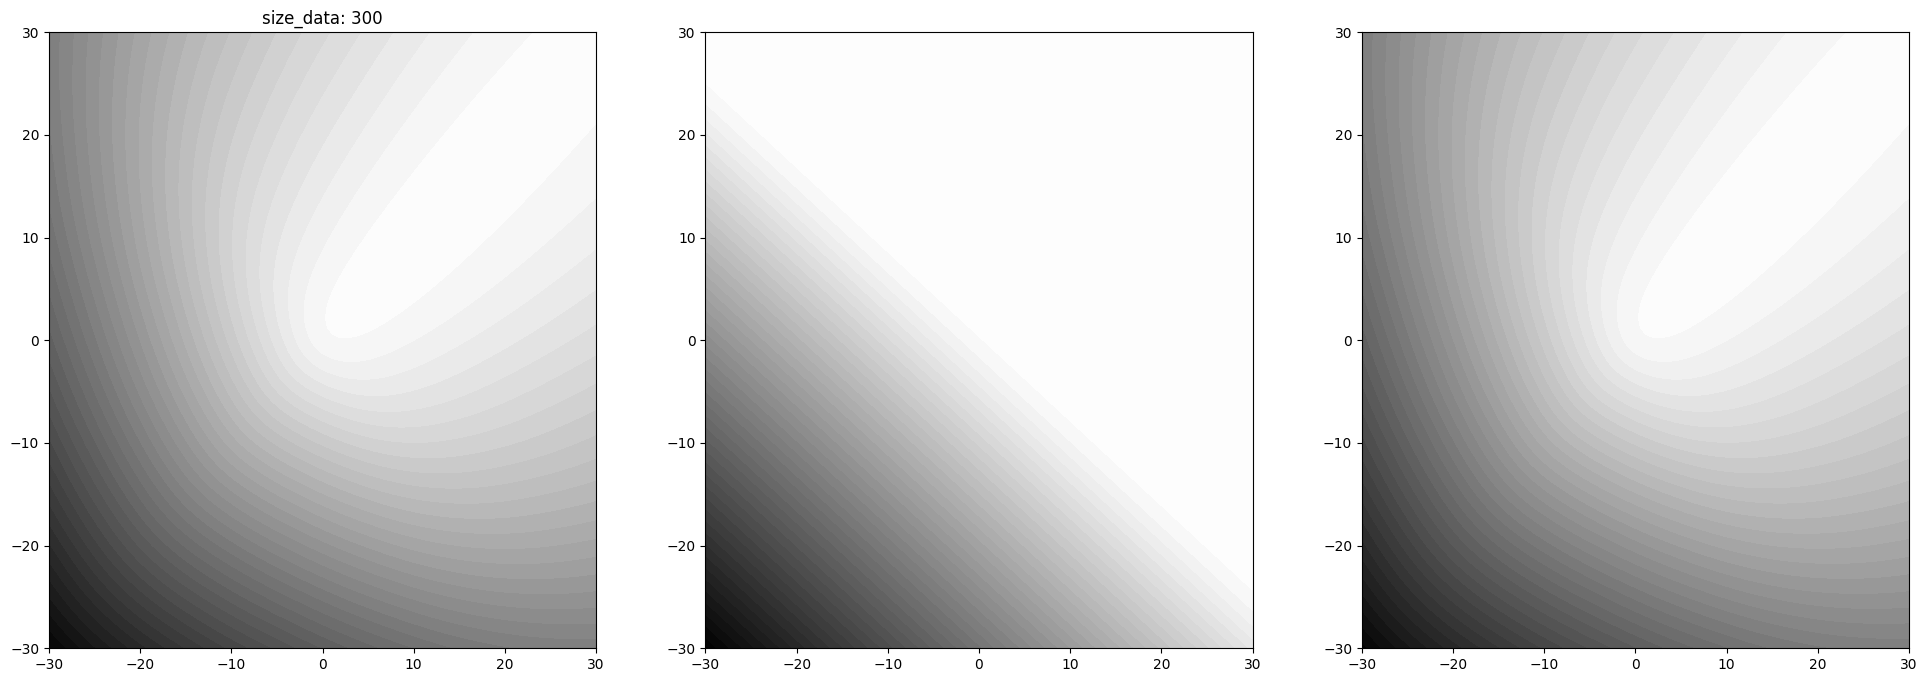

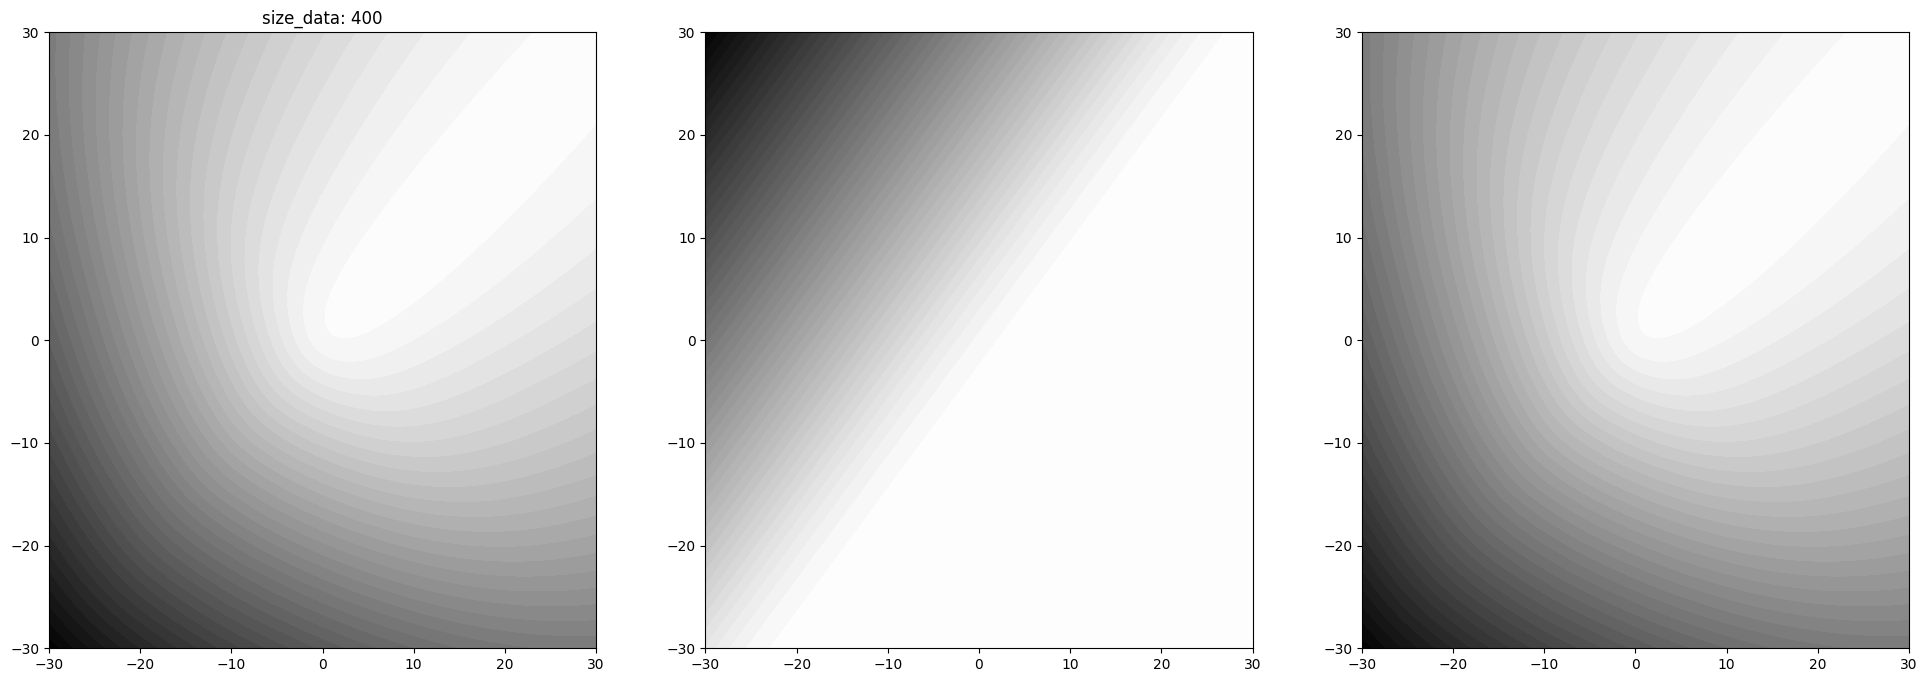

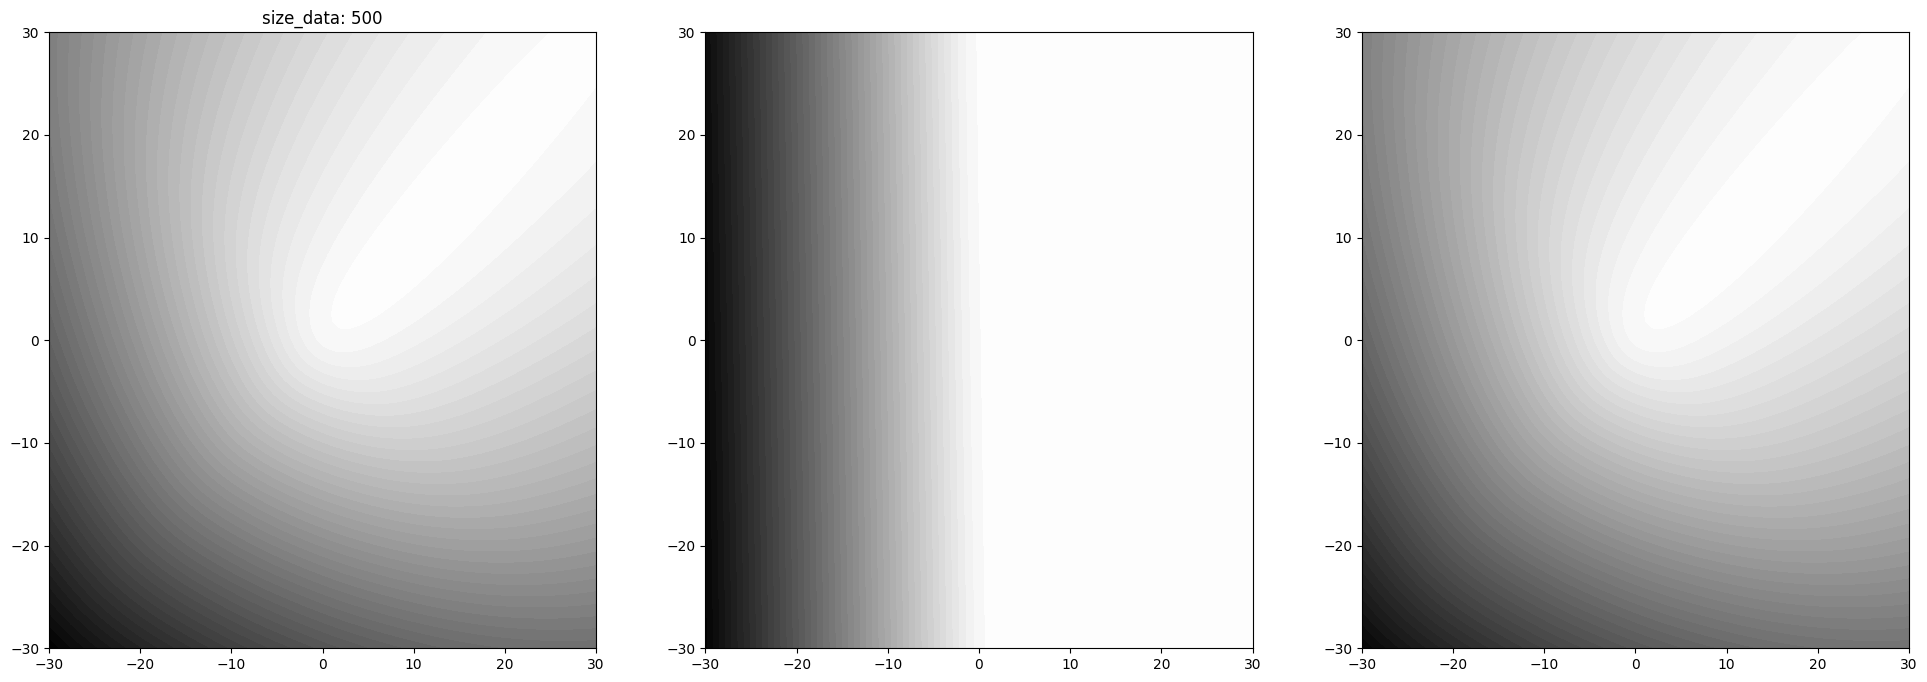

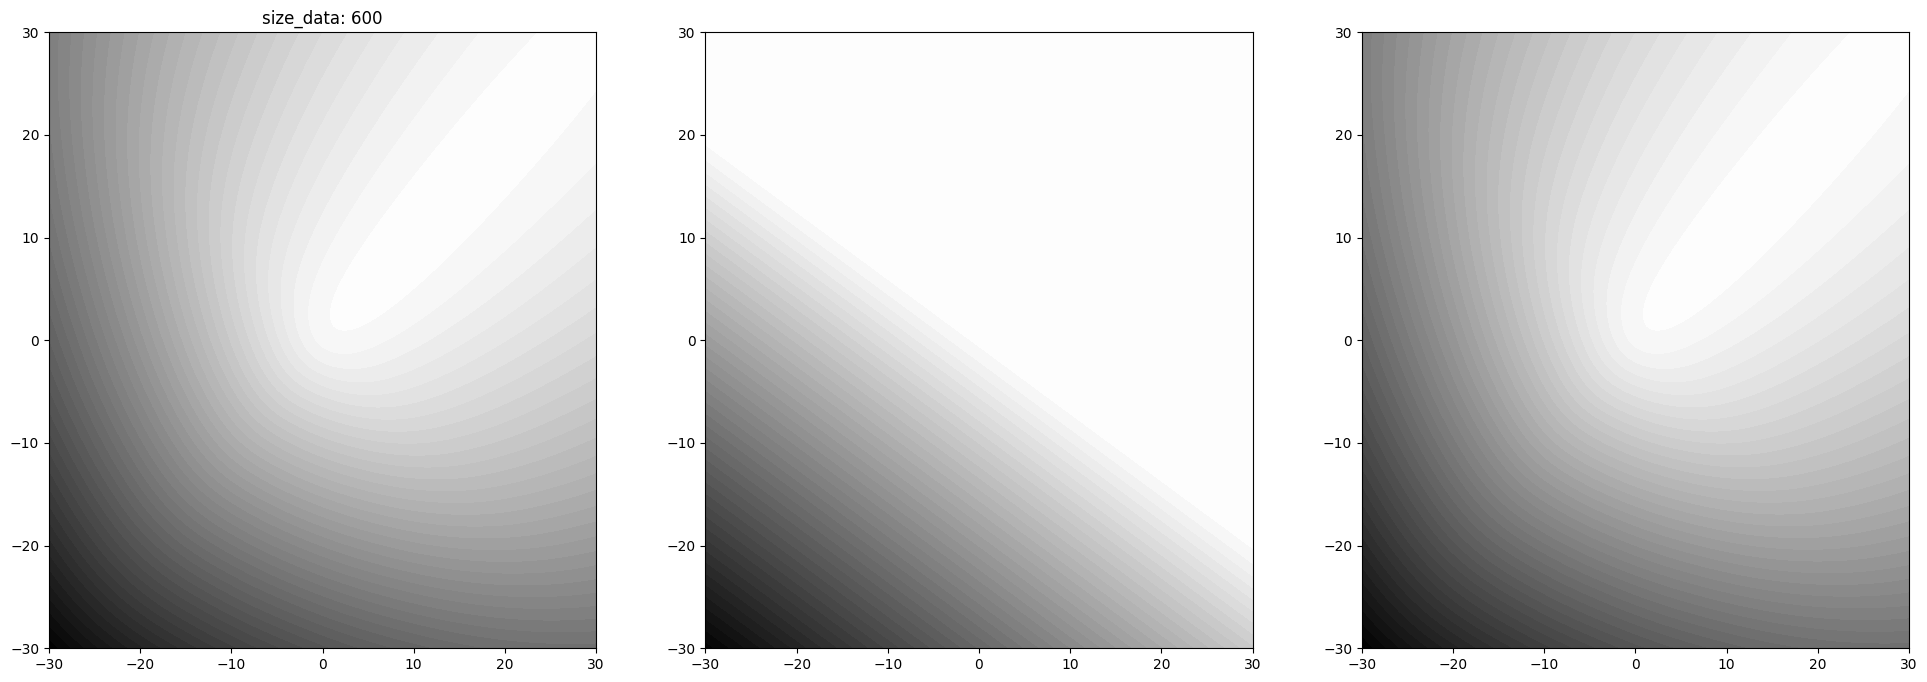

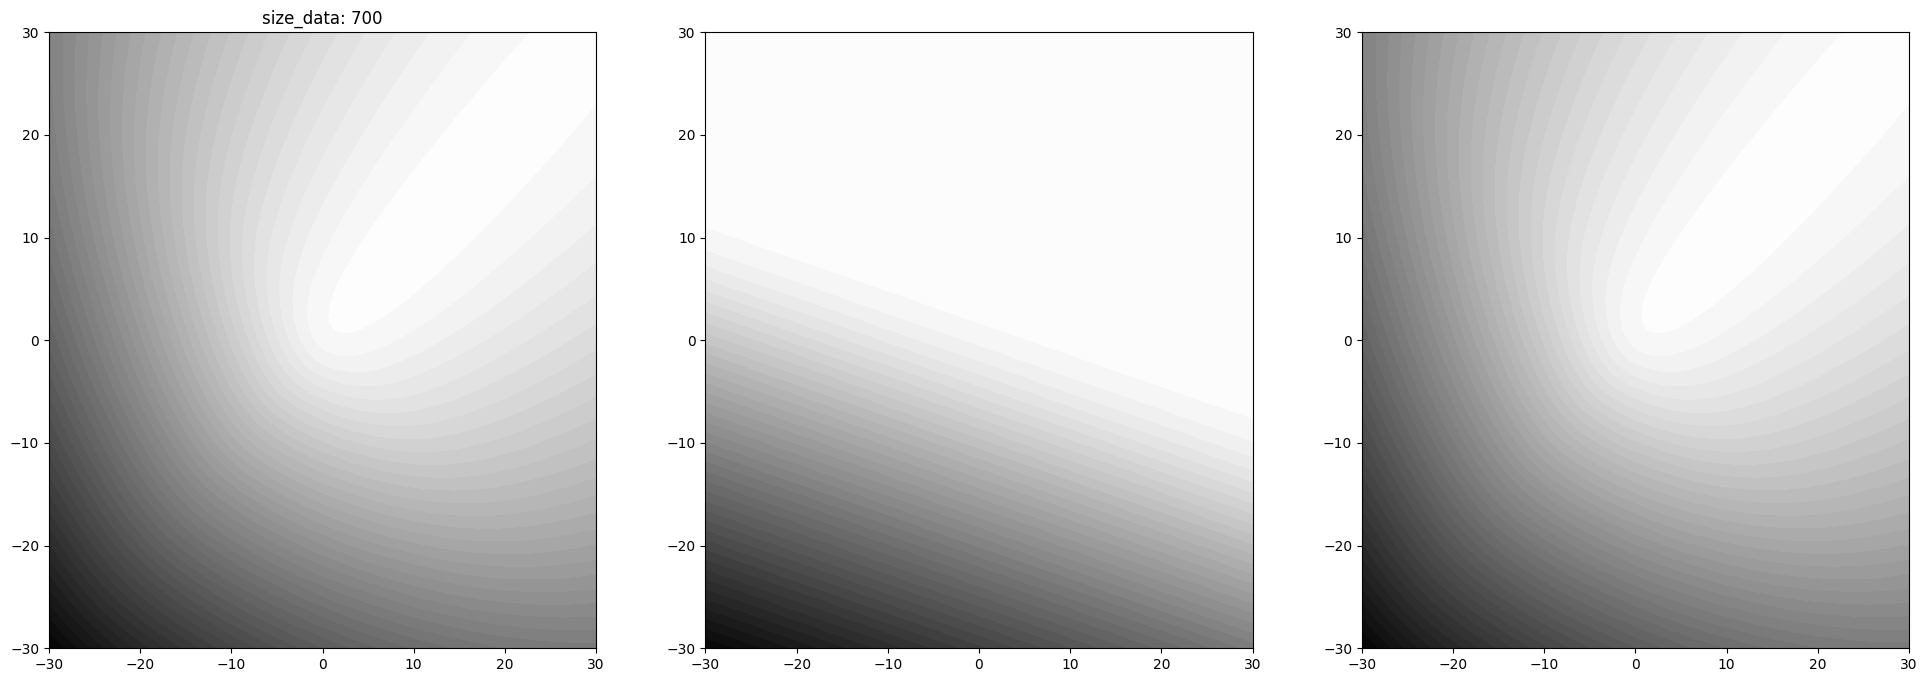

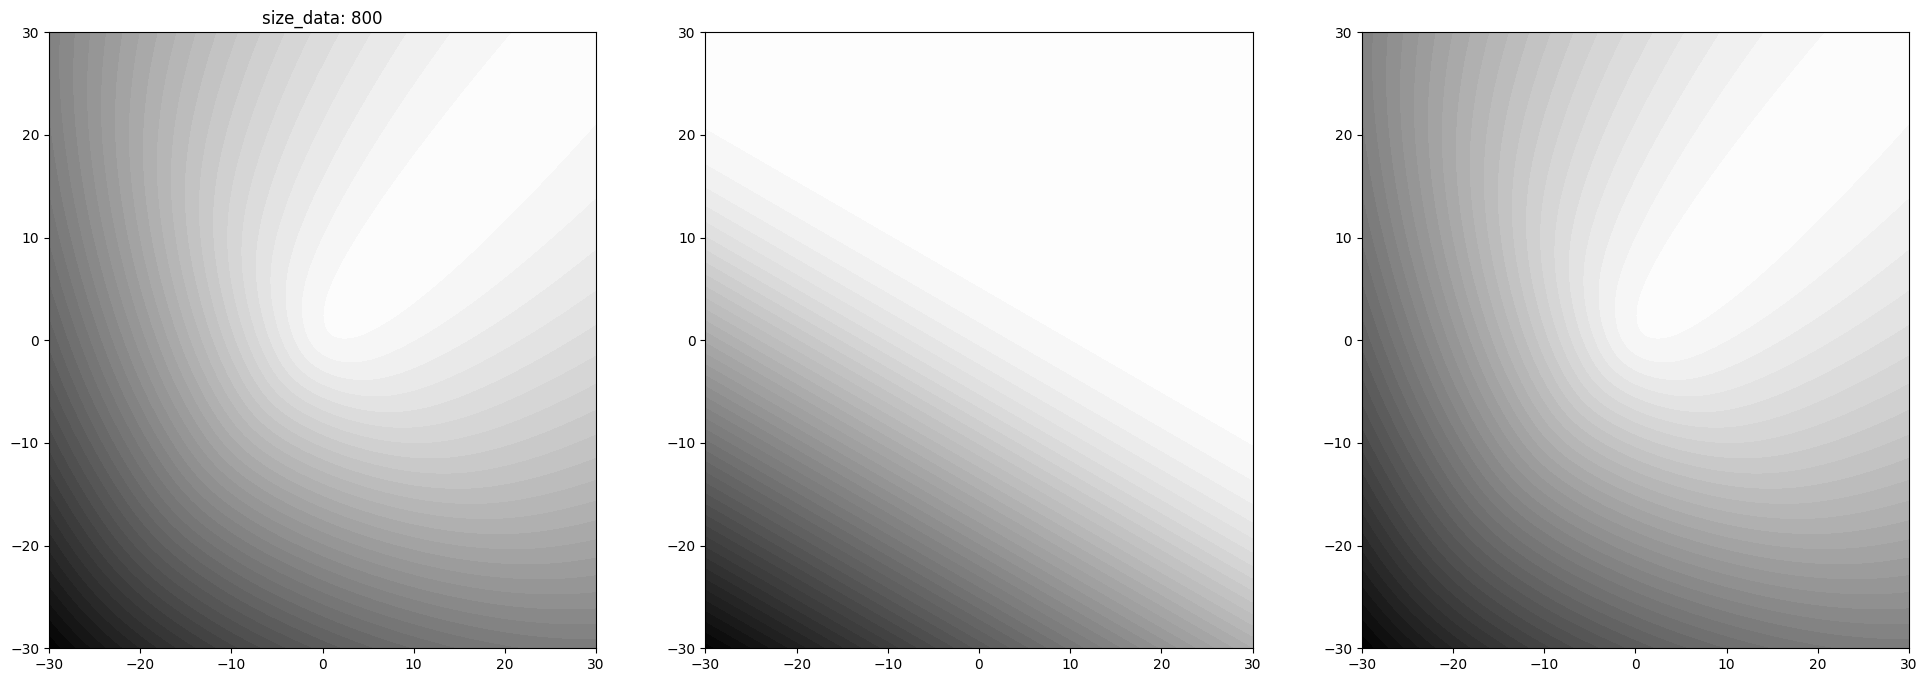

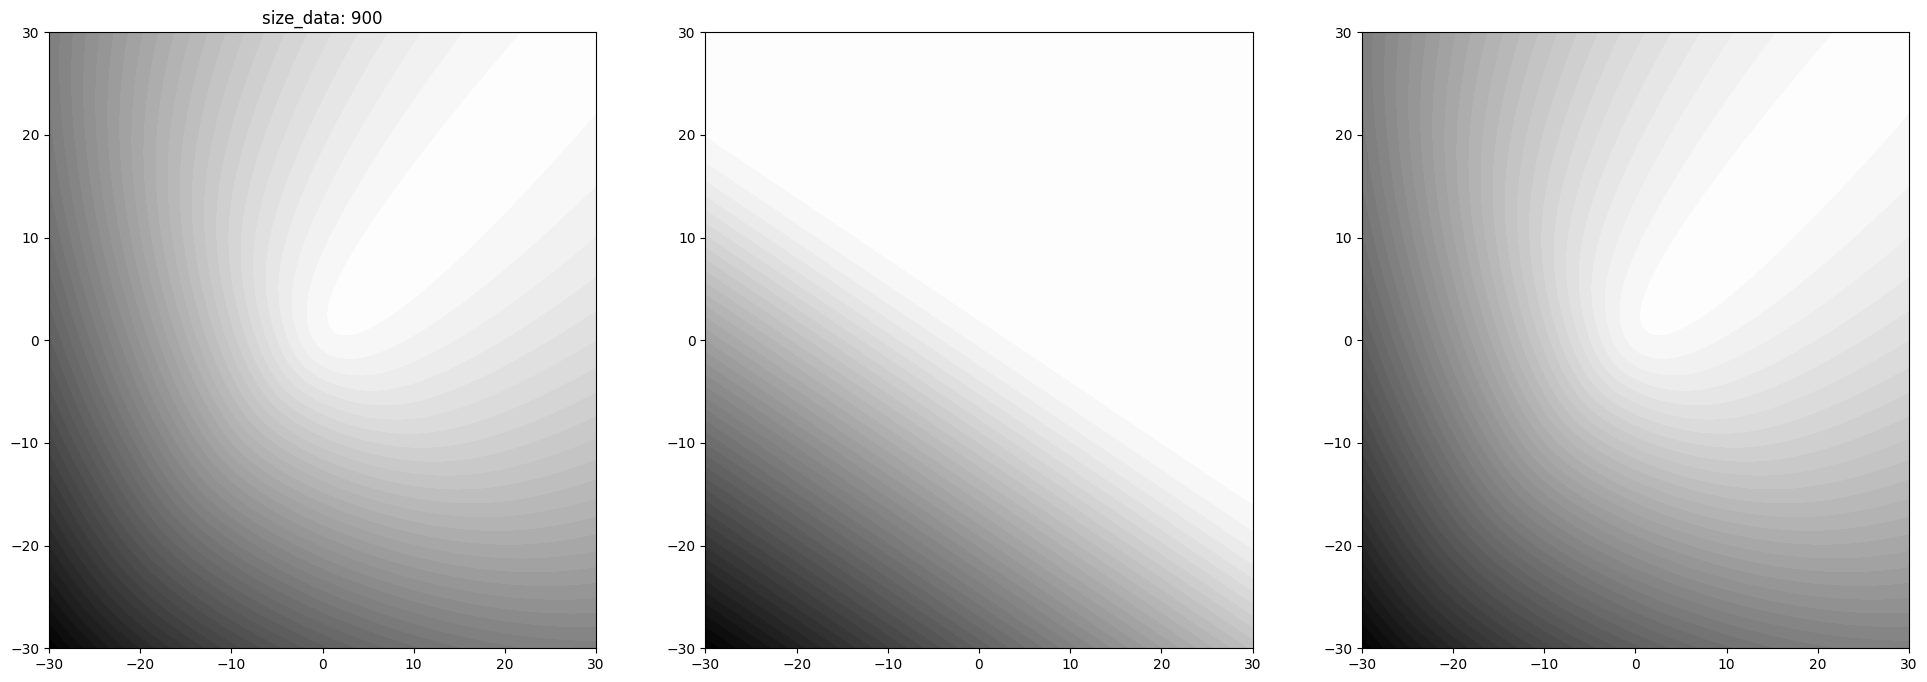

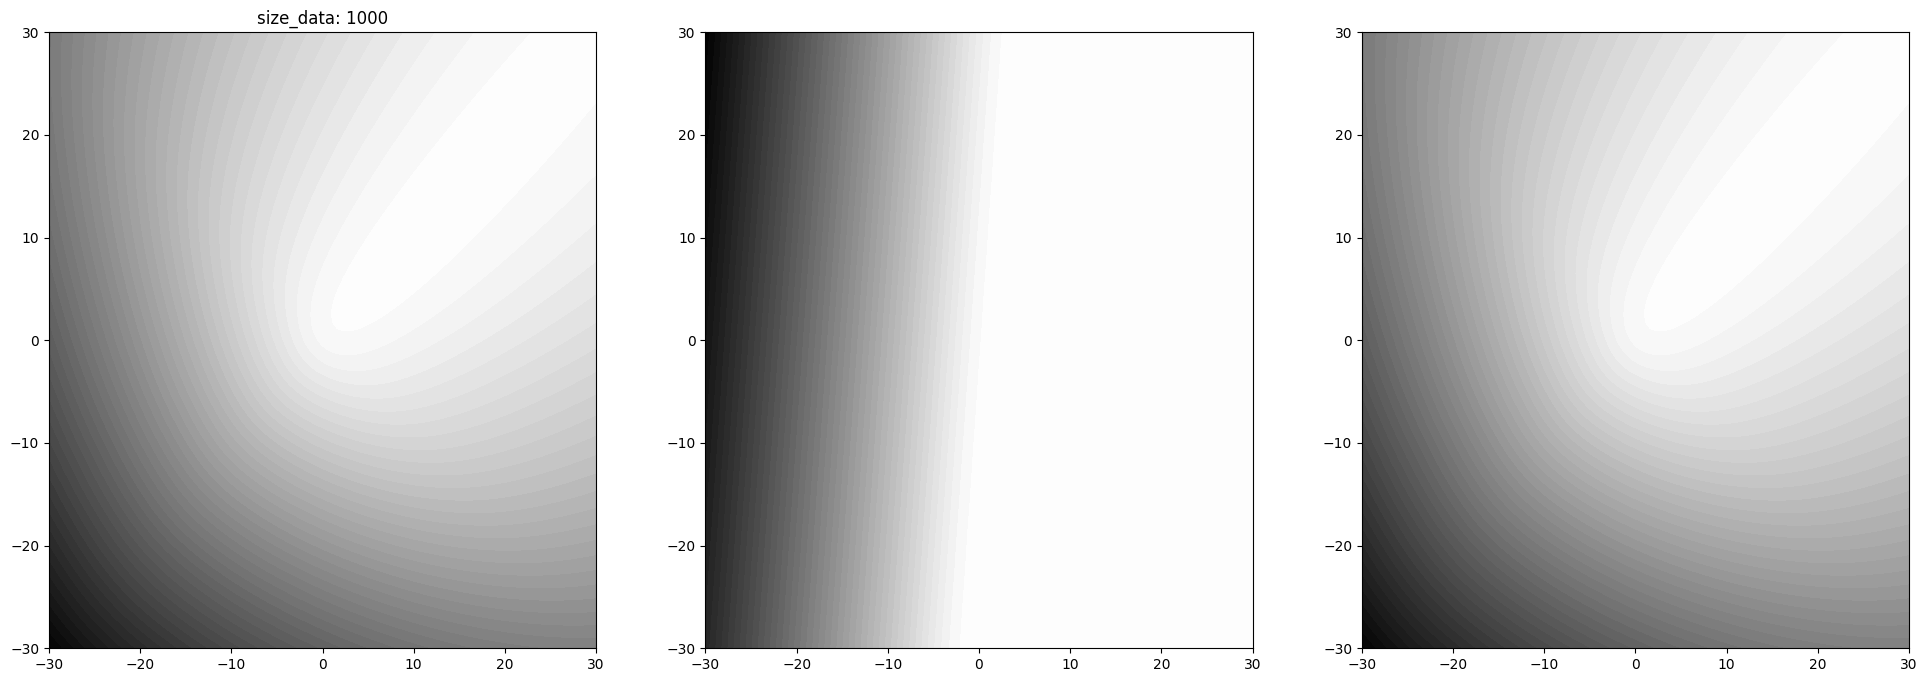

In [8]:
def log_prob_sigma(label_sign, features, w):
    z = label_sign*np.sum(features.reshape((1,-1))*w, axis=-1)
    #return np.abs(z) - np.log(1+np.exp(-z-np.abs(z)))
    return -np.log(1 + np.exp(-z))
    
w1, w2 = np.meshgrid(np.linspace(-3*model_diag.scale_prior,3*model_diag.scale_prior, 101),
                     np.linspace(-3*model_diag.scale_prior,3*model_diag.scale_prior, 101))
shape_mesh = w1.shape

w_plot = np.concatenate([w1.reshape((-1,1)), w2.reshape((-1,1))], axis=-1)
log_prob_prior = -0.5*np.sum((w_plot)**2, axis=-1)/(model_diag.scale_prior**2)
log_prob_prior = log_prob_prior - 0.5*2.0*np.log(2*np.pi) - 0.5*2.0*2.0*np.log(model_diag.scale_prior)

#fig, ax = plt.subplots(1,3, figsize=(20,10))
log_prob_current = log_prob_prior.reshape(shape_mesh)
for i, (feature, label) in enumerate(zip(features_train.cpu().numpy(), labels_train.cpu().numpy())):
    log_prob_likelihood = log_prob_sigma(2*label-1,feature, w_plot).reshape(shape_mesh)
    
    if i < 10:
        plot_on = True
    elif i % 100 == 0:
        plot_on = True
    else:
        plot_on = False
    
    if plot_on:
        fig, ax = plt.subplots(1,3, figsize=(24,8))
        ax[0].contourf(w1, w2, log_prob_current, 50, cmap=plt.get_cmap("gray"))
        ax[1].contourf(w1, w2, log_prob_likelihood, 50, cmap=plt.get_cmap("gray"))
        ax[2].contourf(w1, w2, log_prob_current + log_prob_likelihood, 50, cmap=plt.get_cmap("gray"))
        ax[0].set_title(f"size_data: {i}")
    
    log_prob_current = log_prob_current +  log_prob_likelihood 
    

    

# Plot posterior distribuion vs approximation

Text(0.5, 1.0, 'Diagonal approximation')

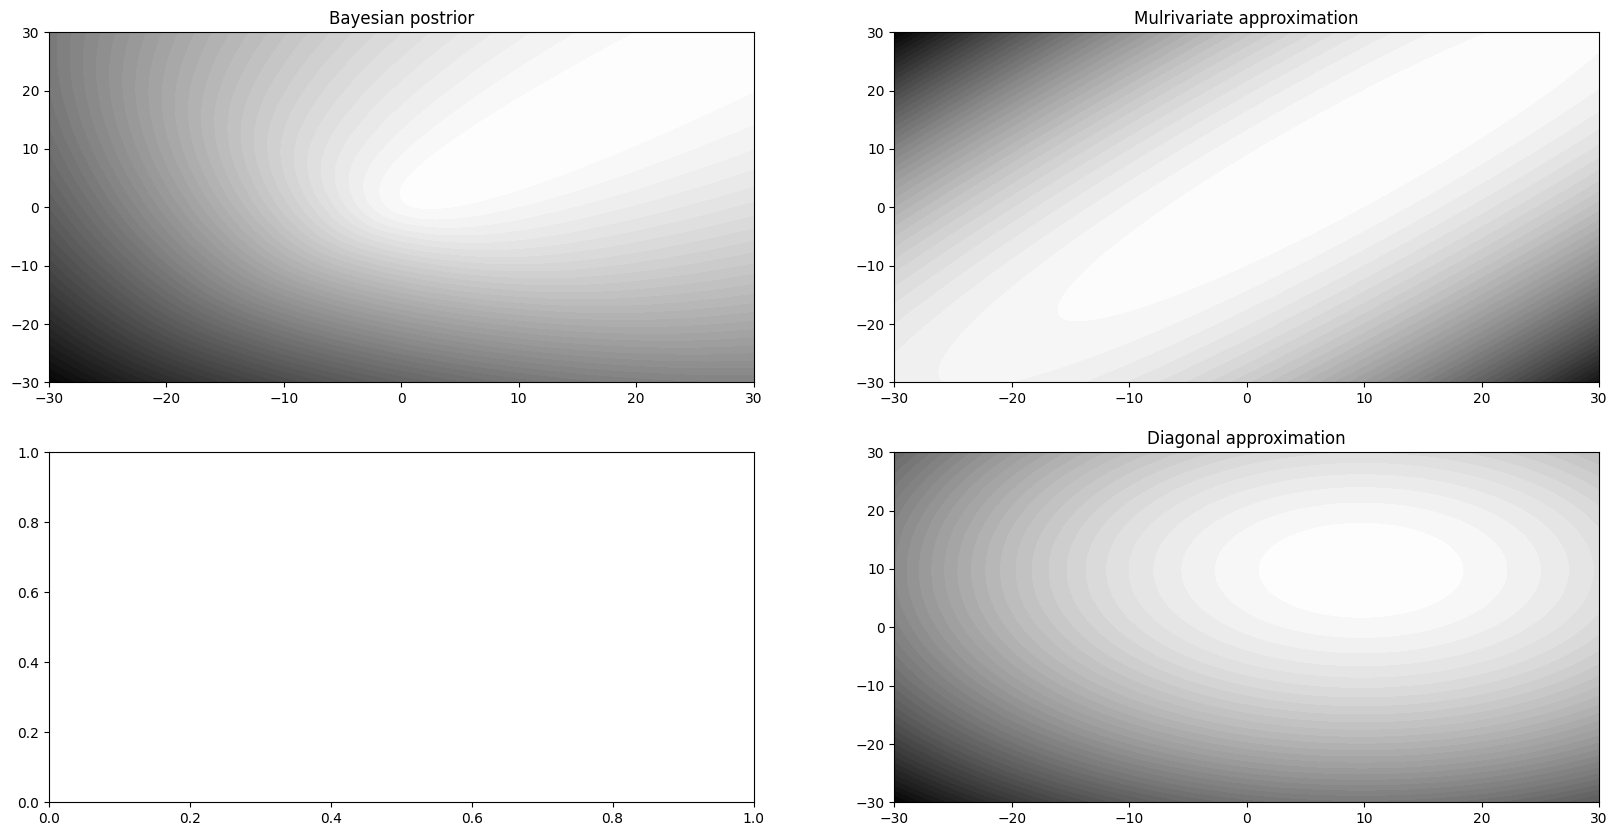

In [9]:
import scipy as sp

w_loc = model_mvn.weights_loc.detach().cpu().numpy().reshape((1,-1))
L     = model_mvn.weights_chol().detach().cpu().numpy()

log_prob_approx_mvn = -0.5*np.sum(np.matmul(w_plot-w_loc, np.linalg.inv(L).T)**2, axis=-1)
log_prob_approx_mvn = log_prob_approx_mvn - 0.5*2.0*np.log(2*np.pi) - 0.5*2.0*np.sum(np.log(np.diag(L)))


w_loc = model_diag.weights_loc.detach().cpu().numpy().reshape((1,-1))
L_diag = torch.exp(model_diag.weights_scale_logdiag).detach().cpu().numpy().reshape((1,-1))

log_prob_approx_diag = -0.5*np.sum(((w_plot-w_loc)/L_diag)**2, axis=-1)
log_prob_approx_diag = log_prob_approx_diag - 0.5*2.0*np.log(2*np.pi) - 0.5*2.0*np.sum(np.log(L_diag))

if True:
    dw = (w1[0,1] - w1[0,0])*(w2[1,0] - w2[0,0])
    log_prob_approx_mvn  = log_prob_approx_mvn - sp.special.logsumexp(log_prob_approx_mvn + np.log(dw))
    log_prob_approx_diag = log_prob_approx_diag - sp.special.logsumexp(log_prob_approx_diag + np.log(dw))
    log_prob_current     = log_prob_current - sp.special.logsumexp(log_prob_current + np.log(dw))
    
 
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].contourf(w1, w2, log_prob_current, 50, cmap=plt.get_cmap("gray"))
ax[0,0].set_title("Bayesian postrior")
ax[0,1].contourf(w1, w2, log_prob_approx_mvn.reshape(w1.shape), 50, cmap=plt.get_cmap("gray"))
ax[0,1].set_title("Mulrivariate approximation")
ax[1,1].contourf(w1, w2, log_prob_approx_diag.reshape(w1.shape), 50, cmap=plt.get_cmap("gray")) 
ax[1,1].set_title("Diagonal approximation")
